# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from scipy.optimize import minimize

***

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

In [3]:
data = pd.read_excel('../data/treasury_quotes_2024-10-31.xlsx', sheet_name='selected quotes').set_index('KYTREASNO')
data.head()

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208042,note,2024-10-31,2023-04-30,2025-04-30,0.495551,0,3.875,99.712500,99.722203,99.717351,0,99.717351,0.044933
208129,note,2024-10-31,2023-10-31,2025-10-31,0.999316,0,5.000,100.641406,100.660819,100.651113,0,100.651113,0.043311
208213,note,2024-10-31,2024-04-30,2026-04-30,1.494867,0,4.875,100.929688,100.960938,100.945312,0,100.945312,0.042327
208302,note,2024-10-31,2024-10-31,2026-10-31,1.998631,0,4.125,99.933594,99.941406,99.937500,0,99.937500,0.041611
207875,note,2024-10-31,2022-04-30,2027-04-30,2.494182,0,2.750,96.750000,96.781250,96.765625,0,96.765625,0.041346


### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [4]:
data1 = data[['quote date', 'maturity date', 'cpn rate', 'price', 'ttm']]

def cashflow_matrix(data, face_val=100, coupon_freq='6ME'):
    # assume the treansuries are ID indexed
    data['maturity date'] = pd.to_datetime(data['maturity date'])
    data['quote date'] = pd.to_datetime(data['quote date'])

    all_dates = pd.date_range(
        start=data['quote date'].min() + relativedelta(months=6),
        end=data['maturity date'].max(),
        freq=coupon_freq
    )

    cash_flow_matrix = pd.DataFrame(0, index=data.index, columns=all_dates)

    for idx, row in data.iterrows():
        payment_dates = pd.date_range(
            start=row['quote date'] + relativedelta(months=6),
            end=row['maturity date'],
            freq=coupon_freq
        )

        cpn_payment = row['cpn rate'] / 100 * face_val / 2
        cash_flow_matrix.loc[idx, payment_dates] = cpn_payment

        cash_flow_matrix.loc[idx, row['maturity date']] = face_val + cpn_payment

    return cash_flow_matrix




In [5]:
cf_mat = cashflow_matrix(data1)

cf_mat

C:\Users\vince\AppData\Local\Temp\ipykernel_4880\735209780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['maturity date'] = pd.to_datetime(data['maturity date'])
C:\Users\vince\AppData\Local\Temp\ipykernel_4880\735209780.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['quote date'] = pd.to_datetime(data['quote date'])
C:\Users\vince\AppData\Local\Temp\ipykernel_4880\735209780.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ver

,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,
208042,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208129,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208213,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208302,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207875,1.3750,1.3750,1.3750,1.3750,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207960,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208044,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208132,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208216,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [7]:
prices = data1[['price']].values

cf_mat_inv = np.linalg.inv(cf_mat)

cf_mat_inv

discount_factors = cf_mat_inv @ prices
discount_factors = pd.DataFrame(discount_factors, index=cf_mat.columns, columns=['Discount Factor'])

discount_factors

,Discount Factor
2025-04-30,0.978220
2025-10-31,0.958103
2026-04-30,0.939358
2026-10-31,0.921067
2027-04-30,0.903034
2027-10-31,0.884856
2028-04-30,0.866327
2028-10-31,0.848120
2029-04-30,0.831110
2029-10-31,0.814462


### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

In [8]:
df_ttm = data1.set_index('maturity date')[['ttm']]
df_ttm = df_ttm.sort_index()

df131 = pd.merge(df_ttm[['ttm']], discount_factors, left_index=True, right_index=True)

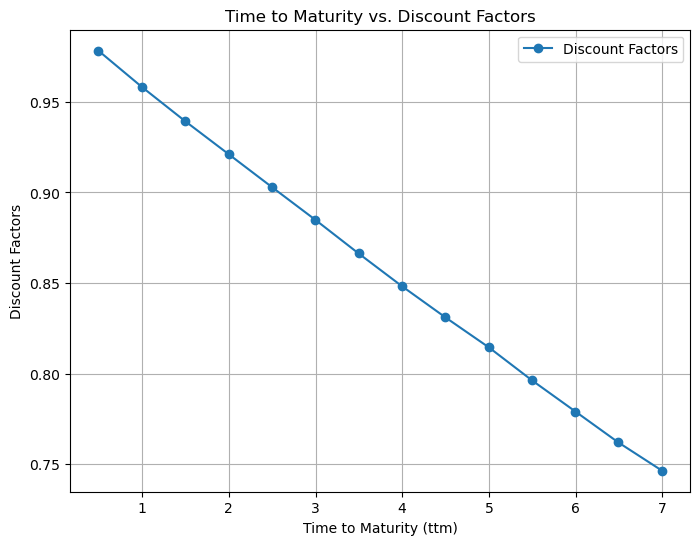

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(df131['ttm'], df131['Discount Factor'], marker='o', linestyle='-', label='Discount Factors')
plt.title('Time to Maturity vs. Discount Factors')
plt.xlabel('Time to Maturity (ttm)')
plt.ylabel('Discount Factors')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
df131['intervals'] = range(1, len(df131) + 1)

df131['continuous discount rate'] = - 2 * np.log(df131['Discount Factor']) / (df131['intervals'])
df131['semiannual discount rate'] = 2 * (1 - np.power(df131['Discount Factor'], 1/df131['intervals']))

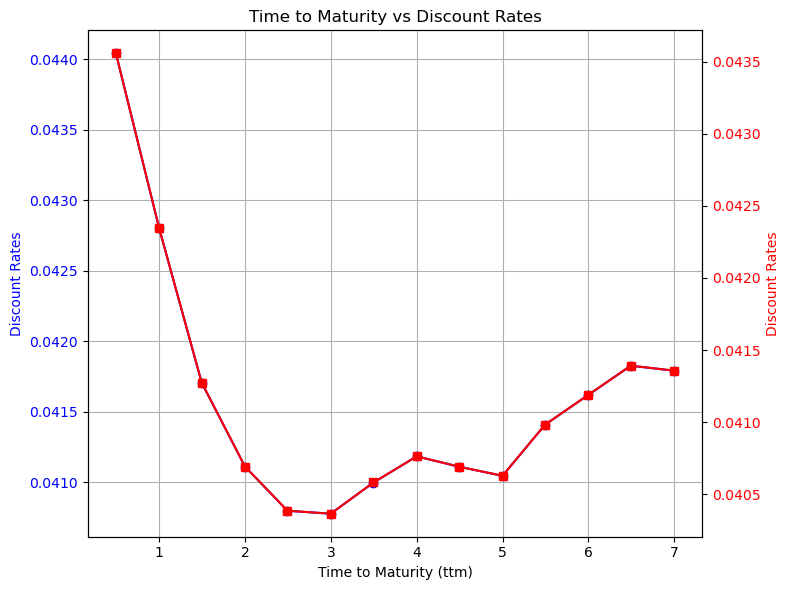

In [11]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(df131['ttm'], df131['continuous discount rate'], marker='o', color='blue', label='Continuous')
ax1.set_xlabel('Time to Maturity (ttm)')
ax1.set_ylabel('Discount Rates', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(df131['ttm'], df131['semiannual discount rate'], marker='s', color='red', label='Semiannual')
ax2.set_ylabel('Discount Rates', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Time to Maturity vs Discount Rates')
fig.tight_layout()
plt.show()

### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [12]:
df14 = data.copy()[['quote date', 'maturity date', 'cpn rate', 'ttm', 'price']]

df14['cpn rate'] = df14['cpn rate']  + 0.5

cf_mat14 = cashflow_matrix(df14)

C:\Users\vince\AppData\Local\Temp\ipykernel_4880\735209780.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.1875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cash_flow_matrix.loc[idx, payment_dates] = cpn_payment
C:\Users\vince\AppData\Local\Temp\ipykernel_4880\735209780.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cash_flow_matrix.loc[idx, payment_dates] = cpn_payment
C:\Users\vince\AppData\Local\Temp\ipykernel_4880\735209780.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.6875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cash_flow_matrix

In [13]:
df14

,quote date,maturity date,cpn rate,ttm,price
KYTREASNO,,,,,
208042,2024-10-31,2025-04-30,4.375,0.495551,99.717351
208129,2024-10-31,2025-10-31,5.500,0.999316,100.651113
208213,2024-10-31,2026-04-30,5.375,1.494867,100.945312
208302,2024-10-31,2026-10-31,4.625,1.998631,99.937500
207875,2024-10-31,2027-04-30,3.250,2.494182,96.765625
207960,2024-10-31,2027-10-31,4.625,2.997947,100.003906
208044,2024-10-31,2028-04-30,4.000,3.496235,97.921875
208132,2024-10-31,2028-10-31,5.375,4.000000,102.603516
208216,2024-10-31,2029-04-30,5.125,4.495551,101.912109


***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

In [52]:
def cashflow_matrix_mod(data, face_val=100, coupon_freq='6ME', date_list=None):
    data['maturity date'] = pd.to_datetime(data['maturity date'])
    data['quote date'] = pd.to_datetime(data['quote date'])

    all_dates = pd.date_range(
        start=data['quote date'].min() + relativedelta(days=1),
        end=data['maturity date'].max(),
        freq='D'
    )

    cash_flow_matrix = pd.DataFrame(0, index=data.index, columns=all_dates)

    for idx, row in data.iterrows():
        if row['type'].lower() == 'bill':
            cash_flow_matrix.loc[idx, row['maturity date']] = face_val
        else:
            payment_dates = pd.date_range(
                end=row['maturity date'],
                periods=(row['maturity date'] - row['quote date']).days // 182 + 1,
                freq='-6ME'
            ).sort_values()

            payment_dates = payment_dates[payment_dates >= row['quote date']]

            cpn_payment = row['cpn rate'] / 100 * face_val / 2

            cash_flow_matrix.loc[idx, payment_dates] = cpn_payment
            cash_flow_matrix.loc[idx, row['maturity date']] += face_val + cpn_payment

    # Drop columns with no cash flows (original behavior)
    cash_flow_matrix = cash_flow_matrix.loc[:, (cash_flow_matrix != 0).any(axis=0)]

    # If date_list is provided, filter for only the specified dates and relevant treasuries
    if date_list is not None:
        date_list = pd.to_datetime(date_list)
        valid_dates = cash_flow_matrix.columns.intersection(date_list)
        valid_treasuries = cash_flow_matrix.loc[:, valid_dates].any(axis=1)  # Keep only treasuries that pay on valid dates
        cash_flow_matrix = cash_flow_matrix.loc[valid_treasuries, valid_dates]

    return cash_flow_matrix.fillna(0)

In [175]:
def cashflow_matrix_mod(data, face_val=100, coupon_freq='6ME', maturity=False):
    data['maturity date'] = pd.to_datetime(data['maturity date'])
    data['quote date'] = pd.to_datetime(data['quote date'])

    all_dates = pd.date_range(
        start=data['quote date'].min() + relativedelta(days=1),
        end=data['maturity date'].max(),
        freq='D'
    )

    cash_flow_matrix = pd.DataFrame(0, index=data.index, columns=all_dates)

    maturity_dates = set(data['maturity date'])  # Store maturity dates
    q_date = data.iloc[0]['quote date']

    for idx, row in data.iterrows():
        if row['type'].lower() == 'bill':
            cash_flow_matrix.loc[idx, row['maturity date']] = face_val
        else:
            payment_dates = pd.date_range(
                end=row['maturity date'],
                periods=(row['maturity date'] - row['quote date']).days // 182 + 1,
                freq='-6ME'
            ).sort_values()

            payment_dates = payment_dates[payment_dates >= row['quote date']]

            cpn_payment = row['cpn rate'] / 100 * face_val / 2

            cash_flow_matrix.loc[idx, payment_dates] = cpn_payment
            cash_flow_matrix.loc[idx, row['maturity date']] += face_val + cpn_payment

    cash_flow_matrix = cash_flow_matrix.fillna(0).drop(columns={q_date})
    cash_flow_matrix = cash_flow_matrix.loc[:, (cash_flow_matrix != 0).any(axis=0)]
    cash_flow_matrix = cash_flow_matrix.sort_index(axis=1)
    
    if maturity:
        non_maturity_cols = list(set(cash_flow_matrix.columns) - set(maturity_dates))

        if non_maturity_cols:
            bonds_with_invalid_cashflows = (cash_flow_matrix[non_maturity_cols] != 0).any(axis=1)
            cash_flow_matrix = cash_flow_matrix.loc[~bonds_with_invalid_cashflows]
        
        new_mat_set = set(data[data.index.isin(set(cash_flow_matrix.index))]['maturity date'])
        cash_flow_matrix = cash_flow_matrix[list(new_mat_set)].sort_index(axis=1)
        #cash_flow_matrix = cash_flow_matrix[list(maturity_dates)].sort_index(axis=1)
    return cash_flow_matrix
    

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [170]:
data_q = pd.read_excel('../data/treasury_quotes_2024-10-31.xlsx', sheet_name='quotes').set_index('KYTREASNO')
data_q.head()

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208246,bill,2024-10-31,2024-07-09,2024-11-05,0.013689,0.972621,0.0,99.947806,99.947917,99.947861,0.000000,99.947861,0.038463
208222,bill,2024-10-31,2024-05-09,2024-11-07,0.019165,0.961670,0.0,99.922356,99.922522,99.922439,0.000000,99.922439,0.040899
208247,bill,2024-10-31,2024-07-16,2024-11-12,0.032854,0.934292,0.0,99.857458,99.857764,99.857611,0.000000,99.857611,0.043844
208223,bill,2024-10-31,2024-05-16,2024-11-14,0.038330,0.923340,0.0,99.832571,99.832932,99.832751,0.000000,99.832751,0.044151
204083,bond,2024-10-31,1994-05-15,2024-11-15,0.041068,0.918478,7.5,100.114004,100.114405,100.114204,3.444293,103.558498,0.045497


In [176]:
df_drop1 = data_q.dropna(subset=['ytm'])
df2_all = df_drop1[df_drop1['ytm'] > 0]

cf_df = cashflow_matrix_mod(df2_all, maturity=True)

C:\Users\vince\AppData\Local\Temp\ipykernel_4880\2981804838.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '103.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cash_flow_matrix.loc[idx, row['maturity date']] += face_val + cpn_payment
C:\Users\vince\AppData\Local\Temp\ipykernel_4880\2981804838.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cash_flow_matrix.loc[idx, payment_dates] = cpn_payment
C:\Users\vince\AppData\Local\Temp\ipykernel_4880\2981804838.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

In [164]:
display(cf_df.head())

display(cf_df.tail())

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2081-10-31,2082-01-31,2082-04-30,2082-07-31,2082-10-31,2083-01-31,2083-04-30,2083-07-31,2083-10-31,2084-01-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0,100,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0,0,100,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0,0,0,100,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,0,0,0,0,103.75,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2081-10-31,2082-01-31,2082-04-30,2082-07-31,2082-10-31,2083-01-31,2083-04-30,2083-07-31,2083-10-31,2084-01-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208107,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0000,2.0625,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000
208149,0,0,0,0,0.0,0,0,0,0,0.0,...,2.3750,0.0000,2.3750,0.000,2.3750,0.000,0.0000,0.000,0.0000,0.000
208178,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0000,2.1250,0.0000,2.125,0.0000,2.125,0.0000,0.000,0.0000,0.000
208233,0,0,0,0,0.0,0,0,0,0,0.0,...,2.3125,0.0000,2.3125,0.000,2.3125,0.000,2.3125,0.000,2.3125,0.000
208279,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0000,2.1250,0.0000,2.125,0.0000,2.125,0.0000,2.125,0.0000,2.125


In [177]:
cf_df.shape

(218, 130)

### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [178]:
price2 = df2_all[['price']]

price2 = price2[price2.index.isin(set(cf_df.index))]

price2.shape

(218, 1)

In [179]:
def estimate_discount_factors(price_df, cf_df):
    """
    Estimates discount factors using OLS regression based on the equation:
        p = C z + e
    where:
        - p: Vector of bond prices from price_df.
        - C: Cash flow matrix from cf_df.
        - z: Estimated discount factors.
        - e: Error term.

    Parameters:
    price_df (pd.DataFrame): DataFrame with treasury number as index and a column 'price'.
    cf_df (pd.DataFrame): DataFrame with treasury number as index and columns as cash flow dates.

    Returns:
    pd.Series: Estimated discount factors indexed by cash flow dates.
    """
    # Ensure indices match between price_df and cf_df
    common_index = price_df.index.intersection(cf_df.index)
    p = price_df.loc[common_index, 'price'].values  # Extract prices
    C = cf_df.loc[common_index].values  # Extract cash flow matrix

    # Perform OLS regression
    model = sm.OLS(p, C)  # No intercept since cash flows sum to price
    results = model.fit()

    # Extract estimated discount factors
    z = pd.DataFrame(results.params, index=cf_df.columns, columns=['Discount Factors'])
    z.index.name = 'date'
    
    return z, results

In [180]:
z, res = estimate_discount_factors(price2, cf_df)

z

,Discount Factors
date,
2024-11-05,0.999479
2024-11-07,0.999224
2024-11-12,0.998576
2024-11-14,0.998328
2024-11-15,0.982190
...,...
2028-02-15,0.931839
2028-02-29,0.927933
2028-03-31,0.924229


In [139]:
mat_date = df2_all[['maturity date','ttm']]

In [181]:
mat_date['maturity date'] = pd.to_datetime(mat_date['maturity date'])
z.index = pd.to_datetime(z.index)
mat_date = mat_date[mat_date['maturity date'].isin(set(z.index))]

comb_df = pd.merge(z, mat_date, left_on=z.index, right_on='maturity date').dropna()

comb_df

,Discount Factors,maturity date,ttm
0,0.999479,2024-11-05,0.013689
1,0.999224,2024-11-07,0.019165
2,0.998576,2024-11-12,0.032854
3,0.998328,2024-11-14,0.038330
4,0.982190,2024-11-15,0.041068
...,...,...,...
213,0.924229,2028-03-31,3.414100
214,0.924229,2028-03-31,3.414100
215,0.921695,2028-04-30,3.496235
216,0.921695,2028-04-30,3.496235


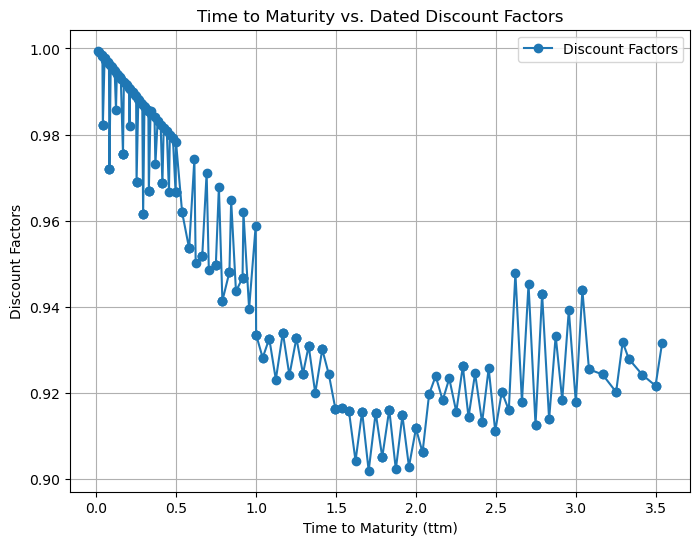

In [182]:
plt.figure(figsize=(8, 6))
plt.plot(comb_df['ttm'], comb_df['Discount Factors'], marker='o', linestyle='-', label='Discount Factors')
plt.title('Time to Maturity vs. Dated Discount Factors')
plt.xlabel('Time to Maturity (ttm)')
plt.ylabel('Discount Factors')
plt.grid(True)
plt.legend()
plt.show()

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

In [200]:
def nelson_siegel(ttm, beta0, beta1, beta2, lmda):
    """Nelson-Seigel yield curve model."""
    term = ttm / lmda
    return beta0 + beta1 * ((1 - np.exp(-term)) / term) + beta2 * (((1 - np.exp(-term)) / term) - np.exp(-term))

def price_error(params, price_ttm_df, cf_df):
    """Objective function: Sum of squared pricing errors."""
    beta0, beta1, beta2, lmda = params
    
    # Compute discount factors using Nelson-Siegel model
    yields = nelson_siegel(price_ttm_df['ttm'].values, beta0, beta1, beta2, lmda)
    discount_factors = np.exp(-yields * price_ttm_df['ttm'].values)
    
    # Ensure discount_factors is properly shaped for element-wise multiplication
    estimated_prices = (cf_df.values * discount_factors[:, None]).sum(axis=1)
    
    # Compute sum of squared errors
    return np.sum((price_ttm_df['price'].values - estimated_prices) ** 2)


def estimate_discount_factors(price_ttm_df, cf_df):
    """Estimate discount factors using Nelson-Seigel model."""
    initial_guess = [0.02, -0.02, 0.02, 1.0]  # Initial values for beta0, beta1, beta2, lmda
    bounds = [(None, None), (None, None), (None, None), (0.001, None)]  # Lambda must be positive
    
    result = minimize(price_error, initial_guess, args=(price_ttm_df, cf_df), bounds=bounds)
    
    if result.success:
        beta0, beta1, beta2, lmda = result.x
        estimated_yields = nelson_siegel(price_ttm_df['ttm'], beta0, beta1, beta2, lmda)
        discount_factors = np.exp(-estimated_yields * price_ttm_df['ttm'])
        
        factors = {'beta0': beta0, 'beta1': beta1, 'beta2': beta2, 'lmda': lmda}
        return factors, pd.Series(discount_factors, index=price_ttm_df.index)
    else:
        raise ValueError("Optimization failed: " + result.message)


In [201]:
mat_date['date'] = mat_date['maturity date']

price_ttm_df = pd.merge(price2, mat_date.set_index('maturity date'), left_on=price2.index, right_on=mat_date.index).rename(columns={'key_0': 'KYTREASNO'}).set_index('KYTREASNO')

price_ttm_df

# price_ttm_df = price_ttm_df.set_index('date')[['price', 'ttm']]


,price,ttm,date
KYTREASNO,,,
208246,99.947861,0.013689,2024-11-05
208222,99.922439,0.019165,2024-11-07
208247,99.857611,0.032854,2024-11-12
208223,99.832751,0.038330,2024-11-14
204083,100.114204,0.041068,2024-11-15
...,...,...,...
207691,90.853516,3.414100,2028-03-31
208032,98.394531,3.414100,2028-03-31
207704,90.648438,3.496235,2028-04-30


In [202]:
cf_df

date,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2027-10-31,2027-11-15,2027-11-30,2027-12-31,2028-01-31,2028-02-15,2028-02-29,2028-03-31,2028-04-30,2028-05-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000
208222,0,100,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000
208247,0,0,100,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000
208223,0,0,0,100,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000
204083,0,0,0,0,103.75,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207691,0,0,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.250,0.0000,0.0000
208032,0,0,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.625,0.0000,0.0000
207704,0,0,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,101.2500,0.0000


In [203]:
estimate_discount_factors(price_ttm_df, cf_df)

({'beta0': -0.027763675644315585,
  'beta1': 0.0869269188111447,
  'beta2': 0.16079569854532155,
  'lmda': 0.6867819290105485},
 KYTREASNO
 208246    0.999181
 208222    0.998848
 208247    0.998003
 208223    0.997661
 204083    0.997488
             ...   
 207691    0.932062
 208032    0.932062
 207704    0.933740
 208044    0.933740
 207215    0.934597
 Name: ttm, Length: 218, dtype: float64)

***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [204]:
from sklearn.decomposition import PCA

In [205]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)

shapes = pd.DataFrame(yields.mean(axis=1),columns=['level'])
shapes['slope'] = yields[30]-yields[1]
shapes['curvature'] = -yields[1] + 2 * yields[10] - yields[30]

DATETHRESH = '2010-01-01'
shapesT = shapes[shapes.index>DATETHRESH]

In [208]:
shapes.describe()

,level,slope,curvature
count,15868.000000,15868.000000,15868.000000
mean,5.463678,1.098446,0.660265
std,2.903979,1.478564,0.975464
min,0.487603,-3.490292,-5.426753
25%,3.464977,-0.021420,0.074945
50%,5.154073,0.997652,0.615611
75%,7.149205,2.109713,1.328883
max,15.259628,4.358273,3.283792


In [209]:
shapes.corr()

,level,slope,curvature
level,1.000000,-0.371060,-0.162638
slope,-0.371060,1.000000,0.650691
curvature,-0.162638,0.650691,1.000000


### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [210]:
pca = PCA(svd_solver='full')
pca.fit(yields)
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_,columns=['Variance explained']).T
pca_var_explained.columns = list(np.arange(1,8,1))
pca_var_explained.style.format('{:.2%}'.format)

,1,2,3,4,5,6,7
Variance explained,97.05%,2.55%,0.30%,0.05%,0.04%,0.02%,0.01%


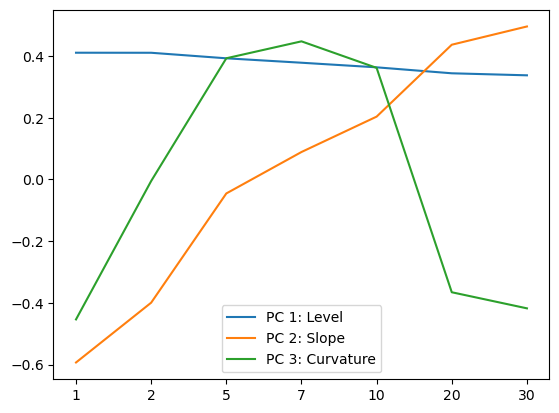

In [211]:
pca_wts = pd.DataFrame(pca.components_,columns=yields.columns)
pca_wts.index = ['PC 1: Level','PC 2: Slope','PC 3: Curvature','PCA 4','PCA 5','PCA 6','PCA 7']
if pca_wts.loc['PC 2: Slope',10]<0:
    pca_wts.loc['PC 2: Slope'] *= -1
if pca_wts.loc['PC 3: Curvature',10]<0:
    pca_wts.loc['PC 3: Curvature'] *= -1
pca_wts.T.iloc[:,0:3].plot();

### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

In [212]:
pca_factors = yields @ pca_wts.T
pd.concat([shapes, pca_factors.iloc[:,0:3]], axis=1, keys=['shapes', 'pca']).corr().loc['shapes', 'pca'].style.format('{:.1%}')

,PC 1: Level,PC 2: Slope,PC 3: Curvature
level,100.0%,1.2%,-0.1%
slope,-38.2%,92.0%,1.0%
curvature,-17.0%,64.6%,69.8%
